# EXPLORATION 13 : CIFAR-10 이미지 생성하기

## 준비한 데이터
- CIFAR-10 Dataset

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


훈련 데이터는 5만장, 테스트 데이터는 1만장으로 구성되어 있다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_img = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


[0, 255] 범위로 되어있는 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화한다.

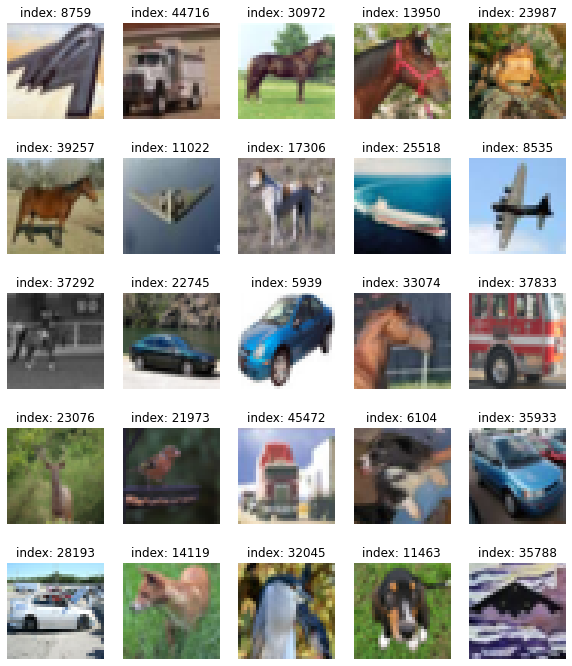

In [5]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_img[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

학습 데이터를 랜덤하게 뽑아 시각화한다.

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices().shuffle().batch() 함수를 사용하여  
데이터셋을 골고루 섞고 미니배치 데이터셋을 구성한다.

## 2. 생성자 모델 구현하기

In [7]:
def make_generator_model():    
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same'))
    
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여  
(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델을 구현한다.

In [9]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [10]:
# 생성자 모델에 입력값으로 노이즈를 넣고 결과 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

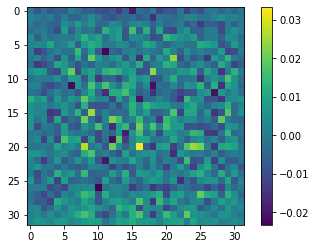

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

아직 모델 학습 전이라 의미는 없다.

## 3. 판별자 모델 구현하기

In [12]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))    
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    # Sixth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [14]:
# 생성자 모델로 생성한 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00039598]], dtype=float32)>

## 4. 손실함수와 최적화 함수 구현하기

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용하는데  
여기서 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로  
이진 교차 엔트로피(binary cross entropy)를 사용한다.  

그리고 from_logits를 True로 설정해 주어야  
BinaryCrossEntropy에 입력된 값을 함수 내부에서  
sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산한다.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

최적화 함수로 Adam을 사용하고 중요한 하이퍼 파라미터인 learning rate는 0.0001로 설정한다.

In [18]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

훈련 과정을 지켜보기 위해 16개의 고정된 seed를 생성한다.

## 5. 훈련과정 상세 기능 구현하기

In [19]:
# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.
@tf.function
def train_step(images):  #(1) 입력 데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # (2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현한다.

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples1/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현한다.

In [30]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8    # matlab 차트의 기본 크기를 15, 8으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history1/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy  
히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현한다.

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints1'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

training_checkpoints 디렉토리에 일정 epoch마다 모델을 저장하는 checkpoint 모듈을 구현한다.

## 6. 학습 과정 진행하기

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [33]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

두번에 나눠서 훈련을 진행했으므로 checkpoint를 통해 모델을 먼저 로드한다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

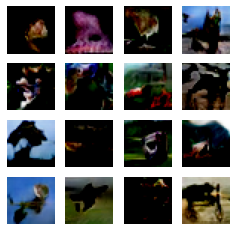

Time for training : 7758 sec


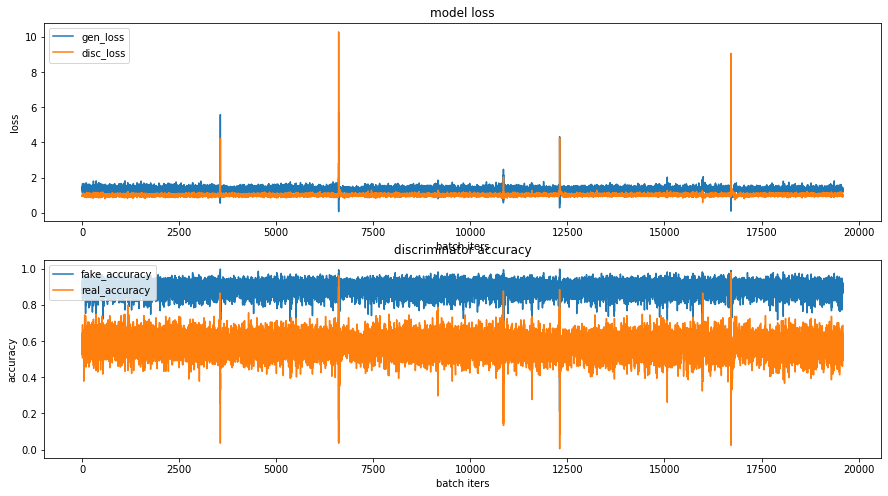

CPU times: user 2h 8min 42s, sys: 56.3 s, total: 2h 9min 38s
Wall time: 2h 9min 20s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

In [36]:
# 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples1/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif

-rw-r--r-- 1 root root 1340940 Aug 29 10:21 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan1.gif


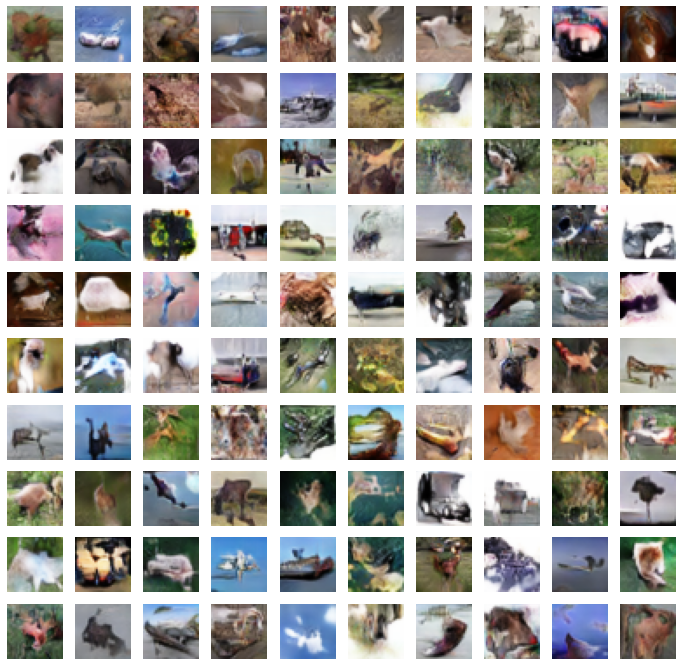

In [37]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints1'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

# 프로젝트 결과

**훈련 과정 개선하기**  
Fashion MNIST 이미지 생성에 사용된 generator, discriminator 모델을 기반으로 훈련을 진행했고  
Fashion MNIST 이미지 생성에 사용된 모델들보다 층을 더 깊게해주어 파라미터 수를 늘려보았다.  
이후 generator의 BatchNormalization도 제거를 해보고, discriminator의 Dropout을 제거 해봤는데  
학습시간이 너무 길어 에폭을 끝까지 하진 못했지만 솔직히 큰 차이가 있어보이지는 않았다.  

**훈련 과정**  
기본적으로 에폭이 클수록 generator의 생성 퀄리티가 올라가는 것 처럼 보이는데  
학습 시간이 너무 길어 무한정 학습을 돌릴수 없어서 에폭을 올리는데 한계가 있었다.  
아래의 훈련 변화 과정은 330에폭을 돌린후 추가로 100에폭을 더 돌린 결과이다.  

뒤늦게 알아차렸는데 추가 100에폭에서 이미지가 갑자기 확 바뀌는걸 보니  
추가 에폭때 코드를 다시 처음부터 돌리면서 16개의 고정된 seed가  
다른 랜덤노이즈로 바뀐게 아닌가 의심이 든다.

**훈련 변화 과정**  

| 첫 330에폭                          | 추가 100에폭                          |
| :-------------------------------- | :-------------------------------- |
| ![330](https://user-images.githubusercontent.com/85026563/131280344-096b5dab-9a04-4928-aa38-1a30a89a97eb.gif) | ![100](https://user-images.githubusercontent.com/85026563/131247095-391db224-b2bf-4dcd-ab0c-c9a5c784eadb.gif) |

**느낀점**  
이렇게 훈련시간이 길었던 적이 없었던 것 같은데 정말 유의미한 제너레이터로 만드려면  
12시간으로도 부족하지 않을까하는 생각이 들었다.  
나도 꽤 많이 시간을 투자했다고 생각했는데 솔직히 결과물이 만족스럽지가 않다.  
결국 이번 노드에서는 시간이 부족해서 다양한 시도를 못한게 너무 아쉽고  
맨 처음에 코드를 다 짜고 주피터 노트북을 작성한 후 학습을 돌려놓고 잠을 잤는데  
아침에 실수로 닫기를 눌러 파일이 전부 날아가서 처음부터 다시 주피터 노트북을 작성했었다.  
다행히 체크포인트 파일은 남아있어서 계속 훈련은 이어서 할 수 있었지만  
중간저장의 필요성을 뼈저리게 느낀 하루였다.  
그리고 체크포인트 저장이 진짜 중요한 기능이라는 걸 느꼈다.  